# Chapter 6: The Haunted DAG & The Causal Terror - Samples

Imagine how selecting topics for a conference works. Imagine that we are scoring with equal weights on two variables:

* Trustworthiness
* Newsworthiness

Let's simulate:

#### Code 6.1

In [3]:
import numpy as np
from scipy import stats

np.random.seed(42)
N = 200
p = 0.1
# uncorrelated newsworthiness and trustworthiness
nw = np.random.normal(size=N)
tw = np.random.normal(size=N)
# select top 10% of combined scores
s = nw + tw
q = np.quantile(s, 1-p)
selected = np.where(s >= q, True, False)
stats.pearsonr(tw[selected], nw[selected])

PearsonRResult(statistic=-0.702031027987863, pvalue=0.0005597087444959316)

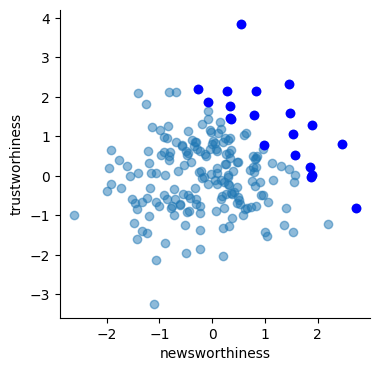

In [4]:
from matplotlib import pyplot as plt


plt.figure(figsize=(4, 4))
ax = plt.subplot()
ax.plot(nw, tw, 'o', alpha=0.5)
ax.plot(nw[selected], tw[selected], 'bo');
ax.set_xlabel('newsworthiness')
ax.set_ylabel('trustworhiness')
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False);

> <span style="color:blue">BERKSON'S PARADOX</span>. Among funded proposals, the most newsworthy studies can actually have less than average trustworhiness (less than 0 in the figure). Is is also known as the **selection-distortion effect**.

> <span style="color:blue">COLLIDER BIAS</span>. Regression will not help finding these scenarios because the act of adding a predictor induces statistical selection within the model.

In this chapter we will investigate three types of ☢️ hazards:
* Multicollinearity;
* Post-treatment bias;
* Collider bias.

## Multicollinearity

What would happen if we add all the variables into a multiregression problem?

> <span style="color:blue">MULTICOLLINARITY</span>. A very strong association between two or more predictor variables.

Our posterior distribution might suggest that none of the variables are  reliably associated with the outcome, even if all of them are.

### Multicollinear Legs

Let's try out an example. Let's relate height (outcome) with both left and right leg size.

#### Code 6.2

In [9]:
import pandas as pd

N = 100
np.random.seed(42)
height = np.random.normal(size=N, loc=10, scale=2)
leg_prop = np.random.uniform(size=N, low=0.4, high=0.5)
leg_left = leg_prop * height + np.random.normal(size=N, loc=0, scale=0.02)
leg_right = leg_prop * height + np.random.normal(size=N, loc=0, scale=0.02)

d = pd.DataFrame({
    'height': height,
    'leg_left': leg_left,
    'leg_right': leg_right,
})
d.head()

,height,leg_left,leg_right
0,10.993428,4.856509,4.860230
1,9.723471,4.134425,4.093350
2,11.295377,4.648250,4.654939
3,13.046060,5.713282,5.651172
4,9.531693,4.723943,4.713700


The average of leg size is 0.45 the height of a person. So we would expect one of the $\beta$ coefficients in a linear regression to be 0.45. But in this case the other one would have to be 0. But of course this is not what happens.

In [11]:
import pymc as pm
from rethinking import precis

In [56]:
def quap(model):
    vars_ = [
        var 
        for val in model.value_vars 
        for var, values in model.rvs_to_values.items() 
        if val == values
    ]
    var_names = [v.name for v in vars_]
    mean_q = pm.find_MAP()
    H = pm.find_hessian(mean_q, vars_)
    cov = np.linalg.inv(H)
    mean = np.concatenate([np.atleast_1d(mean_q[var_]) for var_ in var_names])
    posterior = stats.multivariate_normal(mean=mean, cov=cov)
    return posterior, vars_

with pm.Model() as model:
    sigma = pm.Exponential('sigma', 1)
    bl = pm.Normal('bl', 2, 10)
    br = pm.Normal('br', 2, 10)
    a = pm.Normal('a', 10, 100)
    mu = pm.Deterministic('mu', a + bl * leg_left + br * leg_right)
    h = pm.Normal('h', mu, sigma, observed=height)
    
    post, vars_ = quap(model)

var_names = [v.name for v in vars_]
post_data = pd.DataFrame(post.rvs(10_000), columns=var_names)
precis(post, var_names)

,mean,std,5.5%,94.5%
sigma,0.575534,0.070487,0.462324,0.687491
bl,-0.541176,1.939705,-3.693437,2.554980
br,2.468745,1.940734,-0.626422,5.623392
a,1.306355,0.293711,0.833680,1.770626


The results are very spread. Let's display the posterior means.

#### Code 6.4

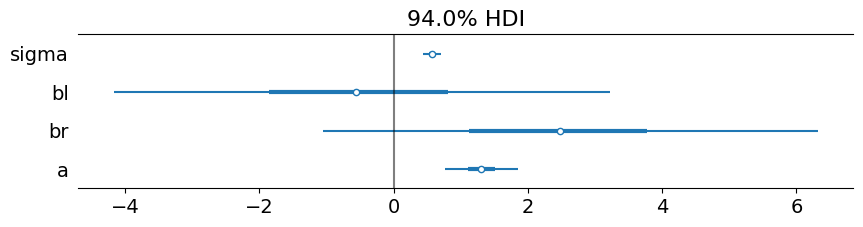

In [65]:
import arviz as az

az.plot_forest(post_data.to_dict('list'), figsize=(10, 2));
plt.axvline(0, color='black', alpha=0.5);

*What is the value of knowing each leg's length, after already knowing the other leg's length*.

#### Code 6.5

Look at the combinations.

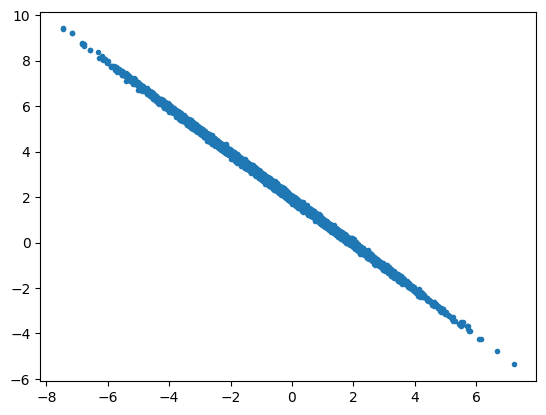

In [69]:
plt.plot(post_data['bl'], post_data['br'], '.');

If we insist on having both variables in the model, then there are an infinite number of combinations possible.

One way to look at this problem, is thinking that we have worked on the following mathematical formula:

$$
\begin{aligned}
y_i &\sim \text{Normal}(\mu_i, \sigma) \\
\mu_i &= \alpha + \beta_1x_i + \beta_2x_i \\
\end{aligned}
$$

Which is equivalent to

$$\mu_i = \alpha + (\beta_1 + \beta_2)x_i$$

Our posterior has still managed to produce a good enough approximation for this sum.

#### Code 6.6

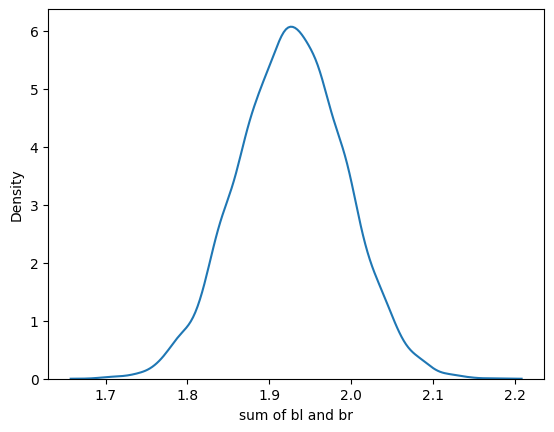

In [75]:
import seaborn as sns

sum_blbr = post_data['br'] + post_data['bl']
sns.kdeplot(sum_blbr);
plt.xlabel('sum of bl and br');

Fitting a regression with only one leg length will get us the same posterior mean.

#### Code 6.7

In [77]:
with pm.Model() as model:
    sigma = pm.Exponential('sigma', 1)
    bl = pm.Normal('bl', 2, 10)
    a = pm.Normal('a', 10, 100)
    mu = pm.Deterministic('mu', a + bl * leg_left)
    h = pm.Normal('h', mu, sigma, observed=height)
    
    post, vars_ = quap(model)

var_names = [v.name for v in vars_]
precis(post, var_names)

,mean,std,5.5%,94.5%
sigma,0.578215,0.070392,0.466446,0.692927
bl,1.925092,0.064431,1.821440,2.027155
a,1.320532,0.289081,0.858486,1.786873


#### Conclusion

When two predictor variables are strongly correlated, including both in the model may lead to confusion. The model will tell us that it can't answer our question. If we are only interested in predictions, then the model will work well, it just won't tell us which leg is more important.

### Multicollinear milk

In real data sets we may not anticipate a clash between highly correlated predictors.

Let's return to the milk problem.

#### Code 6.8

In [78]:
from rethinking import DATA_PATH, standardize

In [81]:
d = pd.read_csv(DATA_PATH.joinpath('milk.csv'), sep=';')
Ko = standardize(d['kcal.per.g'])
F = standardize(d['perc.fat'])
L = standardize(d['perc.lactose'])

We start by modeling `kcal.per.g` as a function of `perc.fat` and `perc.lactose` in two bivariate regressions.

#### Code 6.9

In [86]:
with pm.Model() as model_F:
    sigma = pm.Exponential('sigma', 1)
    bF = pm.Normal('bF', 0, 0.5)
    a = pm.Normal('a', 0, 0.2)
    mu = pm.Deterministic('mu', a + bF * F)
    K = pm.Normal('K', mu, sigma, observed=Ko)
    
    post, vars_ = quap(model_F)

var_names = [v.name for v in vars_]
precis(post, var_names)

,mean,std,5.5%,94.5%
sigma,0.453130,0.130062,0.245214,0.658574
bF,0.861497,0.083777,0.726746,0.994409
a,-0.000605,0.077475,-0.123800,0.121725


In [85]:
var_names = [v.name for v in vars_]
precis(post, var_names)

with pm.Model() as model_L:
    sigma = pm.Exponential('sigma', 1)
    bL = pm.Normal('bL', 0, 0.5)
    a = pm.Normal('a', 0, 0.2)
    mu = pm.Deterministic('mu', a + bL * L)
    K = pm.Normal('K', mu, sigma, observed=Ko)
    
    post, vars_ = quap(model_L)

var_names = [v.name for v in vars_]
precis(post, var_names)

,mean,std,5.5%,94.5%
sigma,0.380700,0.129594,0.173772,0.588212
bL,-0.902694,0.072431,-1.018861,-0.787923
a,-0.000587,0.066922,-0.105790,0.107308


Both Lactose and Fat have good predictor power only in different directions. But what happens if we join both?

#### Code 6.10

In [88]:
var_names = [v.name for v in vars_]
precis(post, var_names)

with pm.Model() as model:
    sigma = pm.Exponential('sigma', 1)
    bL = pm.Normal('bL', 0, 0.5)
    bF = pm.Normal('bF', 0, 0.5)
    a = pm.Normal('a', 0, 0.2)
    mu = pm.Deterministic('mu', a + bL * L + bF * F)
    K = pm.Normal('K', mu, sigma, observed=Ko)
    
    post, vars_ = quap(model)

var_names = [v.name for v in vars_]
precis(post, var_names)

,mean,std,5.5%,94.5%
sigma,0.377230,0.131797,0.165327,0.583740
bL,-0.679035,0.183076,-0.975678,-0.392583
bF,0.243266,0.182571,-0.053686,0.531306
a,0.000791,0.065681,-0.103170,0.105181


This is the same phenomenon as in the legs example. To simplify the visualization of it, we can use a **pairs plot**.

#### Code 6.11

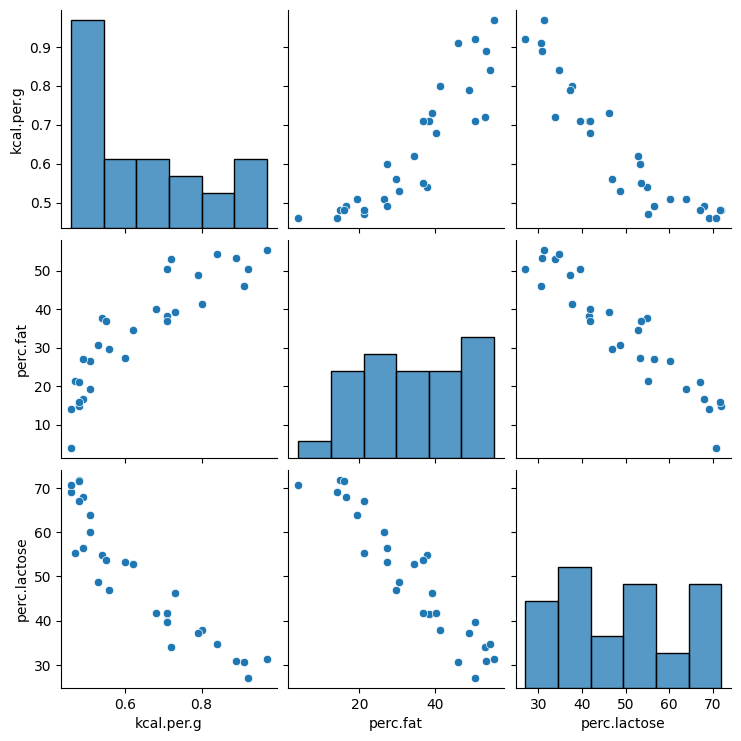

In [94]:
sns.pairplot(d[["kcal.per.g", "perc.fat", "perc.lactose"]]);

In the middle row and right-most plot, we can see that `perc.fat` and `perc.lactose` have a very high correlation, which means that knowing one, makes the use of the other predictor redundant.

> Pairwise correlations are not the problem. It is the conditional associations—not correlations—that matter.

In this case, it is more likely that another variable influences both Lactose and Fat and these influence the Kilocalories.

> <span style="color:blue">NON-IDENTIFIABILITY</span>. Family of problems where multicollinearity belongs. These problems exist when data or model make it impossible to identify the value of parameters.

#### Code 6.12

Simulating multicollinearity

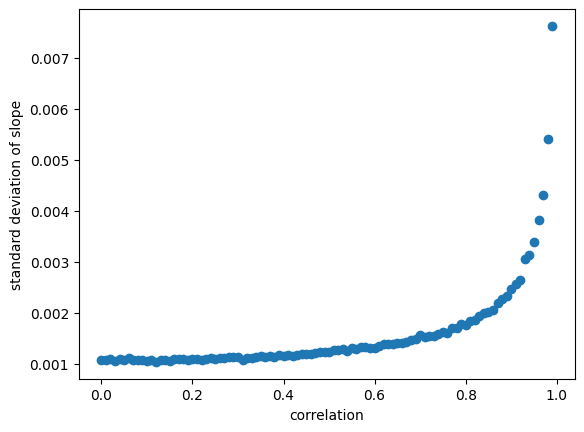

In [95]:
from scipy.optimize import curve_fit


def mv(x, a, b, c):
    return a + x[0] * b + x[1] * c


def sim_coll(r=0.9):
    x = np.random.normal(loc=r * d["perc.fat"], scale=np.sqrt((1 - r**2) * np.var(d["perc.fat"])))
    _, cov = curve_fit(mv, (d["perc.fat"], x), d["kcal.per.g"])
    return np.sqrt(np.diag(cov))[-1]


def rep_sim_coll(r=0.9, n=100):
    return np.mean([sim_coll(r) for i in range(n)])


r_seq = np.arange(0, 1, 0.01)
stdev = list(map(rep_sim_coll, r_seq))

plt.scatter(r_seq, stdev)
plt.xlabel("correlation")
plt.ylabel("standard deviation of slope");

## Post-treatment bias